In [4]:
import datetime
import gc
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import lightgbm as lgb

import shap
shap.initjs()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'svg' 

from preprocessing import load_messages, translit

### Загрузка и предварительная очистка данных 
Для исследования мы испоьзовали свежий дамп слака ODS от 06 марта 2021 года.<br>
Каналы jobs и jobs hr. Загрузим сообщения в pandas df и очистим от лишней информации.

In [5]:
messages = load_messages('jobs', 'jobs_hr')


Загружено 47767 cообщений
	Удалены техничексие сообщения: 6864 сообщений
	Дата и время округлены до секунд и переведены в datetime формат
	Текст приведен к маленьким буквам и очищен от лишних пробелов
Осталось 40903 cообщений


### Кол-во сообщений

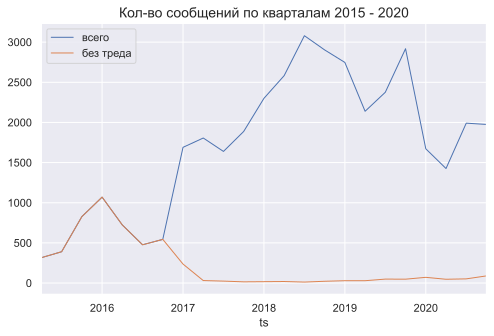

In [6]:
plt.figure(figsize = (8, 5))
messages[messages.ts.dt.year < 2021].resample('Q', on = 'ts')['ts'].count().plot(linewidth=1,
                                                                                 label='всего')
messages[(messages.thread_ts.isna()) & 
         (messages.ts.dt.year < 2021)].resample('Q', on = 'ts')['ts'].count().plot(linewidth=1,
                                                                                   label='без треда')
plt.legend()
plt.title('Кол-во сообщений по кварталам 2015 - 2020', size=14)
plt.show()

Общее кол-во сообщений достигло <b>максимума в 3 квартале 2018 года</b>.<br>
После этого активность снижалась - резкое <b>падение активности произошло в 2020 году</b>

#### Что это коронакризис или хайп по data science уже прошел?

Здесь мы смотрим на все сообщения - это и сами вакансии и комментарии пользователей.<br>
До 2017 года тредов вообще не было и все сообщения сыпались в общий канал.<br>
У части сообщений и сейчас нет треда - если никто не оставил комментарий.<br>

Для дальнейшего анализа нам нужно отделать сообщения с вакансиями от комментариев пользователей.<br>
Самый простой подход - это считать вакансией все сообщения с которых начинается тред (thread_ts = ts).<br>
Но тогда мы потеряем всю статистику за 2015-2016 года.<p>
    
Второй вариант - это обучить простую модель на этой метке и разделить с ее помощью сообщения без треда.<br>

### Классификация сообщений на вакансии и комментарии

В качесстве признаков будет использовать count по всем словам в сообщении.

In [6]:
# CountVectorizer для текста
countvectorizer = CountVectorizer(ngram_range=(1, 2), max_features=2000)
countvectorizer.fit(messages['text'])
word_cols = countvectorizer.get_feature_names()
word_cols = ['_' + translit(col) + f'_{i}' for i, col in enumerate(word_cols)]

# Добавлеям колонки с count по словам
messages = pd.concat((messages, pd.DataFrame(countvectorizer.transform(messages['text']).toarray(), 
                                 columns=word_cols)), axis=1)

# Делим на трейн и тест и обучаем модель
df = messages[~messages['thread_ts'].isna()].reset_index(drop=True)
df['is_job'] = (df['thread_ts'] == df['ts']).astype('int8')
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, word_cols], df['is_job'],
                                                    test_size = 0.33, random_state = 555)
gbm1 = lgb.LGBMClassifier(num_leaves=7, n_estimators=200, feature_fraction=0.3, bagging_fraction=0.5)
gbm1.fit(X_train, y_train)

# Помечяем вакансии новой моделью
messages['is_job'] = gbm1.predict(messages.loc[:, word_cols])
messages = messages.loc[:,[i for i in messages.columns if i not in word_cols]]

del X_train, y_train, df
gc.collect()

3877

#### Качество модели
<p>Качества этой простой модели более чем достаточно для поставленной задачи.<br>
Тем более, что разметка для обучения шумная и не на 100% точная.<p>

In [7]:
# Считаем метрики
accuracy_baseline = round(sum(y_test == 0) / len(y_test) * 100, 1)
print(f'Accuracy для наивной модели {accuracy_baseline}')
pred = gbm1.predict(X_test)
accuracy_model = round(sum(y_test == pred) / len(y_test) * 100, 1)
print(f'Accuracy для модели {accuracy_model}')
print(f'F1 score {f1_score(y_test, pred)}')

Accuracy для наивной модели 93.3
Accuracy для модели 99.6
F1 score 0.9670050761421319


#### Важность признаков
Вакансии и комментарии легко сплитятся по используемым словам.
Например на вакансию указывают такие слова: 
<li> навыки: python, sql, data, английский
<li> ссылки и email: http, https, mailto
<li> слова связанные с вилкой зп: вилка, от, fork, 200, 50 и т.д.
<li> другие слова часто встречаемые в описании вакансий: опыт, привет (в комментах люди редко здороваются), на, ищем, офис, москва, требования<p>
    
На комментарий указывают разговорные слова характерные для ответов:<br>
вот, просто, так, уже, есть, gt (использование цитаты)<p>

Ниже можно посомотреть top50 признаков из модели по версии shap

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


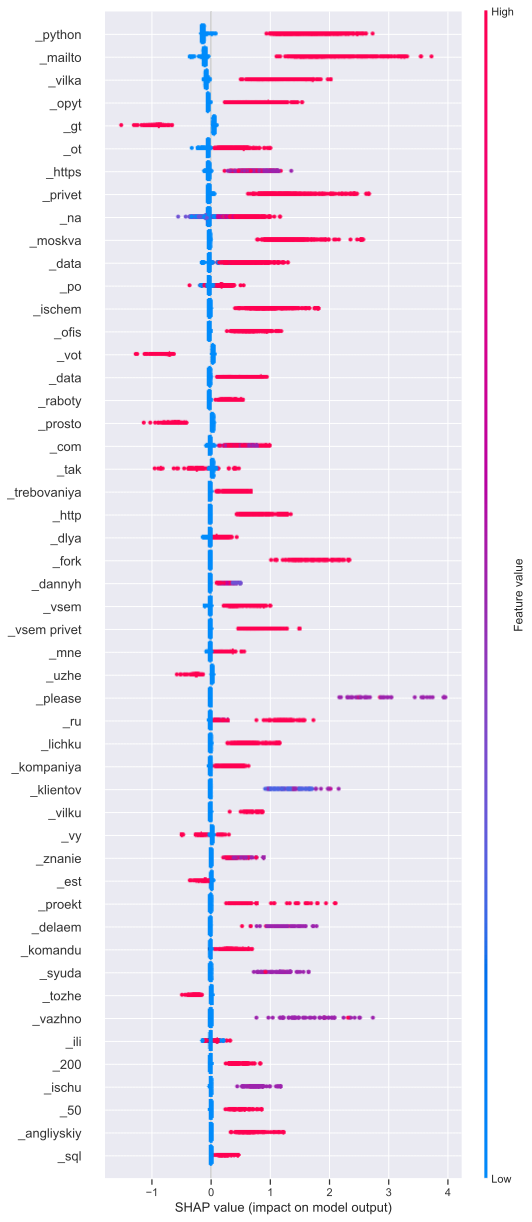

In [16]:
# Нарисуем шап для модели
explainer = shap.TreeExplainer(gbm1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test, max_display=50)

### Кол-во сообщений с вакансиями

Теперь, с помощью нашей модели можно выделить только вакансии и посмотреть на их динамику<br>
Паника отменяется, товарищи, <b>кол-во вакансий по прежнему растет!</b><br>
К концу 2020 года - было чуть меньше 100 вакансий в месяц, а за февраль 2021 уже почти 140!

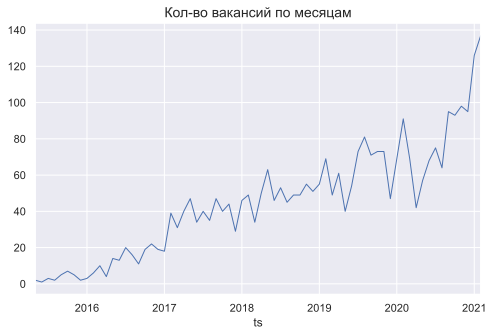

In [29]:
plt.figure(figsize = (8, 5))
messages[(messages.is_job==1) & 
         (messages.ts < '2021-03-01')].resample('M', on = 'ts')['ts'].count().plot(linewidth=1)
plt.title('Кол-во вакансий по месяцам', size=14)
plt.show()

### В какой месяц искать работу?

In [70]:
from sklearn.linear_model import LinearRegression

In [75]:
month = messages[(messages.is_job == 1) &
                 (messages.ts.dt.year > 2015) &
                 (messages.ts.dt.year < 2021)].resample('M', on = 'ts').agg({'ts': 'count'})  
month.columns = ['count']
month['month'] = month.index.month
month['order'] = [*range(1, len(month)+1)]
month = pd.concat([month, pd.get_dummies(month.month)], axis=1)
reg = LinearRegression()
cols =  [i for i in month.columns if i not in ['count', 'month']]
reg.fit(month.loc[:, cols], month['count'])
month['pred'] = reg.predict(month.loc[:, cols])

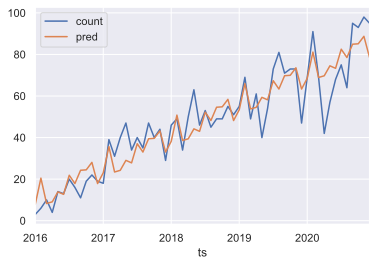

In [77]:
month.loc[:,['count', 'pred']].plot()